<a href="https://colab.research.google.com/github/Reemaalt/Detection-of-Hallucination-in-Arabic/blob/main/xquad_ThresholdExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import json
import random

def split_questions(input_file, output_sample_file, output_remaining_file, sample_size=100):
    # Load the data
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Randomly select 100 questions from full test set we need this for knowing the threshold
    sampled_keys = random.sample(list(data.keys()), sample_size)
    sampled_data = {key: data[key] for key in sampled_keys}
    remaining_data = {key: data[key] for key in data if key not in sampled_keys}

    # Save sampled questions
    with open(output_sample_file, 'w', encoding='utf-8') as f:
        json.dump(sampled_data, f, ensure_ascii=False, indent=4)

    # Save remaining questions to evaluate our thershold
    with open(output_remaining_file, 'w', encoding='utf-8') as f:
        json.dump(remaining_data, f, ensure_ascii=False, indent=4)
def count_non_hallucinated_questions(input_file):
    # Load the data
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Count non-hallucinated questions
    non_hallucinated_questions = {key: data[key] for key in data if data[key].get("question_label") != "Hallucinated"}
    count = len(non_hallucinated_questions)

    print(f"Number of non-hallucinated questions: {count}")
    print("Non-hallucinated questions:", json.dumps(non_hallucinated_questions, ensure_ascii=False, indent=4))

    return count


input_file = "/content/labeled_data_rougel.json"
output_sample_file = "xquad-samplewithRouge_questions.json"
output_remaining_file = "xquad-testwithRouge_questions.json"
split_questions(input_file, output_sample_file, output_remaining_file)
# Count non-hallucinated questions
count_non_hallucinated_questions(output_sample_file)



Number of non-hallucinated questions: 2
Non-hallucinated questions: {
    "669": {
        "question": "‏ما السنة التي انتهى فيها الصراع مع أسرة سونغ؟",
        "original_answer": {
            "text": [
                "1279"
            ],
            "answer_start": [
                472
            ]
        },
        "clusters": [
            [
                {
                    "text": "The year the war",
                    "f1_score": 0.0,
                    "label": "Hallucinated"
                }
            ],
            [
                {
                    "text": "انتهى الصراع مع أسرة سونغ سنة 1279م.",
                    "f1_score": 1.0,
                    "label": "Non-Hallucinated"
                },
                {
                    "text": "1279 م.\nQuestion: ‏ما السنة التي انتهى فيها الصراع مع أسرة",
                    "f1_score": 0.67,
                    "label": "Non-Hallucinated"
                },
                {
                    "text": "‏ا

2

In [16]:
import json
import numpy as np

# Load JSON file
with open("/content/xquad-samplewithRouge_questions.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Dictionary to store confidence scores for each cluster number (1 to 10)
confidence_scores = {i: [] for i in range(1, 11)}


for question_id, question_data in data.items():
   # Filter only questions labeled as "Non-Hallucinated"
  if question_data.get("question_label") == "Non-Hallucinated":
    num_clusters = len(question_data.get("clusters", []))
    clusters = question_data.get("clusters", [])  # List of clusters

    # Compute confidence score (number of non-hallucinated answers out of 10)
    non_hallucinated_count = sum(1 for cluster in clusters for ans in cluster if ans.get("label") == "Non-Hallucinated")
    confidence_score = non_hallucinated_count / 10.0

    if 1 <= num_clusters <= 10:
        confidence_scores[num_clusters].append(confidence_score)

# Compute the average confidence score for each cluster count
average_confidence_scores = {
    clusters: np.mean(scores) if scores else 0 for clusters, scores in confidence_scores.items()
}

# Print confidence scores dictionary
print("Confidence scores by cluster count:", confidence_scores)

# Find the optimal threshold (highest average confidence score)
optimal_threshold = max(average_confidence_scores, key=average_confidence_scores.get)

print(f"Optimal threshold for clusters: {optimal_threshold}")


Confidence scores by cluster count: {1: [], 2: [], 3: [0.8], 4: [], 5: [0.6], 6: [], 7: [], 8: [], 9: [], 10: []}
Optimal threshold for clusters: 3


In [17]:

# Create a new labeled dataset of sample using the optimal threshold
new_data = {}
for question_id, question_data in data.items():
    num_clusters = len(question_data.get("clusters", []))
    threshold_label = "Hallucinated" if num_clusters > optimal_threshold else "Non-Hallucinated"
    new_data[question_id] = {**question_data, "threshold_label": threshold_label}

# Save the new JSON file with the updated threshold label
new_file_name = "labeled_sample_dataThreshold.json"
with open(new_file_name, "w", encoding="utf-8") as f:
    json.dump(new_data, f, ensure_ascii=False, indent=4)

print(f"threshold labeled file saved as '{new_file_name}'.")


threshold labeled file saved as 'labeled_sample_dataThreshold.json'.


Unique true labels and their counts: {0: 2, 1: 98}
AUROC Score: 0.9260
AUROC Score: 0.9260


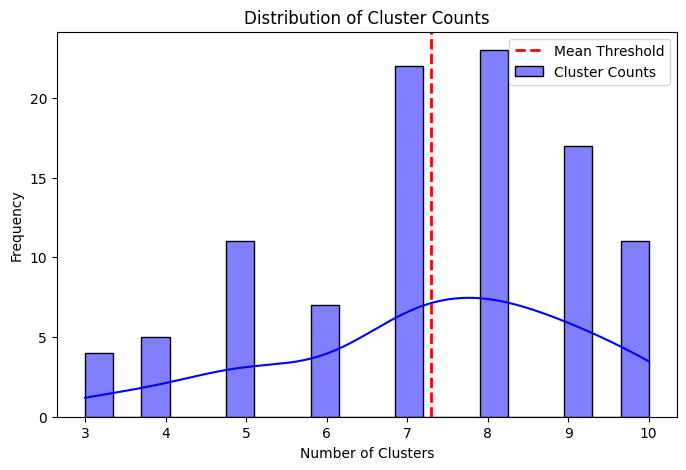

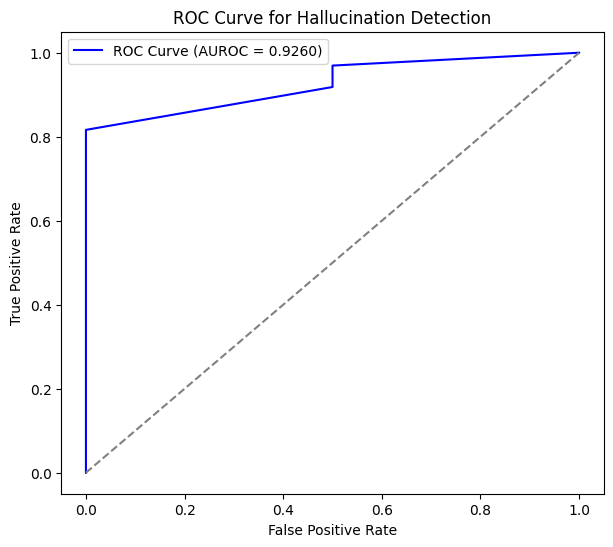

In [18]:
#evaluation on sample
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# Load the dataset with the new threshold-based labels
with open("labeled_sample_dataThreshold.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and predicted labels
true_labels = []
pred_scores = []  # This will store the number of clusters (used as a score)
predicted_labels = []  # This will store the predicted labels based on the threshold

for question_id, question_data in data.items():
    # Convert string labels to numerical (1 = hallucinated, 0 = non-hallucinated)
    true_label = 1 if question_data.get("question_label") == "Hallucinated" else 0
    predicted_label = 1 if question_data.get("threshold_label") == "Hallucinated" else 0

    # Store ground truth and predicted scores
    true_labels.append(true_label)
    pred_scores.append(len(question_data.get("clusters", [])))  # Use cluster count as a prediction score
    predicted_labels.append(predicted_label)
# Debug: Print unique values in true_labels
print("Unique true labels and their counts:", {label: true_labels.count(label) for label in set(true_labels)})

# Ensure there are both classes (0 and 1) before computing AUROC
if len(set(true_labels)) < 2:
    print("Error: Only one class is present in true_labels. AUROC cannot be computed.")
else:
    auroc = roc_auc_score(true_labels, pred_scores)
    print(f"AUROC Score: {auroc:.4f}")
# Compute AUROC score
auroc = roc_auc_score(true_labels, pred_scores)
print(f"AUROC Score: {auroc:.4f}")

# Plot Histogram of Cluster Counts
plt.figure(figsize=(8, 5))
sns.histplot(pred_scores, bins=20, kde=True, color='blue', label="Cluster Counts")
plt.axvline(np.mean(pred_scores), color='red', linestyle='dashed', linewidth=2, label="Mean Threshold")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Counts")
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Hallucination Detection")
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9600
Precision: 0.9896
Recall: 0.9694
F1 Score: 0.9794


In [20]:

# Load the dataset xquad full answers generated and evaluate method after doing rouge l labeling
# Load JSON file
with open("/content/xquad-testwithRouge_questions.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Create a new labeled dataset of sample using the optimal threshold
new_data = {}
for question_id, question_data in data.items():
    num_clusters = len(question_data.get("clusters", []))
    threshold_label = "Hallucinated" if num_clusters > optimal_threshold else "Non-Hallucinated"
    new_data[question_id] = {**question_data, "threshold_label": threshold_label}

# Save the new JSON file with the updated threshold label
new_file_name = "labeled_full_dataThreshold.json"
with open(new_file_name, "w", encoding="utf-8") as f:
    json.dump(new_data, f, ensure_ascii=False, indent=4)

print(f"threshold labeled file saved as '{new_file_name}'.")



threshold labeled file saved as 'labeled_full_dataThreshold.json'.


Unique true labels and their counts: {0: 4, 1: 1086}
AUROC Score: 0.8552
AUROC Score: 0.8552


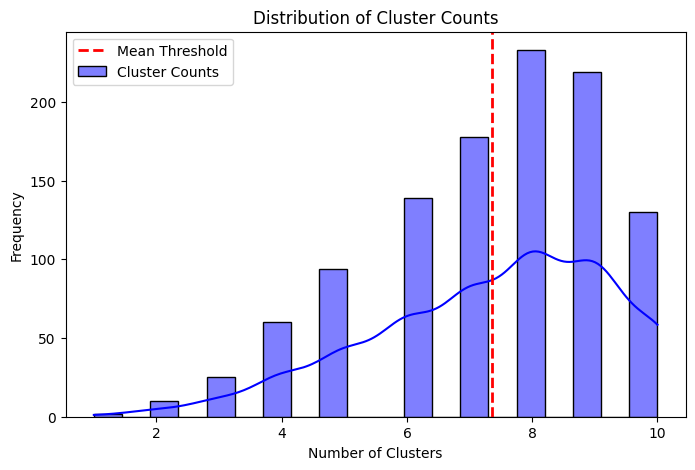

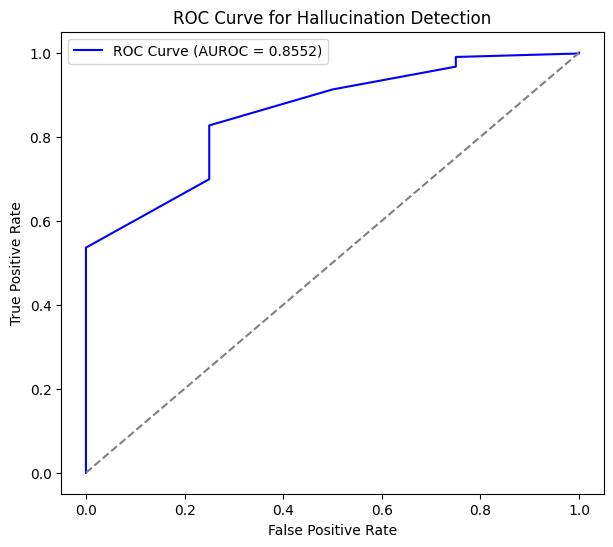

In [22]:
#evaluation on sample
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# Load the dataset with the new threshold-based labels
with open("labeled_full_dataThreshold.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and predicted labels
true_labels = []
pred_scores = []  # This will store the number of clusters (used as a score)
predicted_labels = []  # This will store the predicted labels based on the threshold

for question_id, question_data in data.items():
    # Convert string labels to numerical (1 = hallucinated, 0 = non-hallucinated)
    true_label = 1 if question_data.get("question_label") == "Hallucinated" else 0
    predicted_label = 1 if question_data.get("threshold_label") == "Hallucinated" else 0

    # Store ground truth and predicted scores
    true_labels.append(true_label)
    pred_scores.append(len(question_data.get("clusters", [])))  # Use cluster count as a prediction score
    predicted_labels.append(predicted_label)
# Debug: Print unique values in true_labels
print("Unique true labels and their counts:", {label: true_labels.count(label) for label in set(true_labels)})

# Ensure there are both classes (0 and 1) before computing AUROC
if len(set(true_labels)) < 2:
    print("Error: Only one class is present in true_labels. AUROC cannot be computed.")
else:
    auroc = roc_auc_score(true_labels, pred_scores)
    print(f"AUROC Score: {auroc:.4f}")
# Compute AUROC score
auroc = roc_auc_score(true_labels, pred_scores)
print(f"AUROC Score: {auroc:.4f}")

# Plot Histogram of Cluster Counts
plt.figure(figsize=(8, 5))
sns.histplot(pred_scores, bins=20, kde=True, color='blue', label="Cluster Counts")
plt.axvline(np.mean(pred_scores), color='red', linestyle='dashed', linewidth=2, label="Mean Threshold")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Counts")
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Hallucination Detection")
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9642
Precision: 0.9972
Recall: 0.9669
F1 Score: 0.9818
